In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('housing.csv')
len(df)

20640

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,near_bay
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,near_bay
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,near_bay
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,near_bay
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,near_bay


&nbsp;

&nbsp;

# EDA

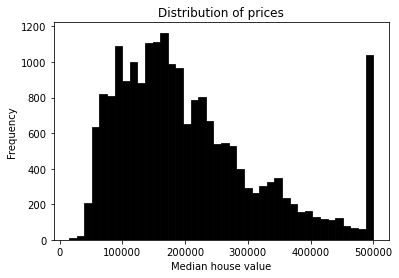

In [5]:
plt.figure(figsize=(6, 4))

sns.histplot(df.median_house_value, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Median house value')
plt.title('Distribution of prices')

plt.show()

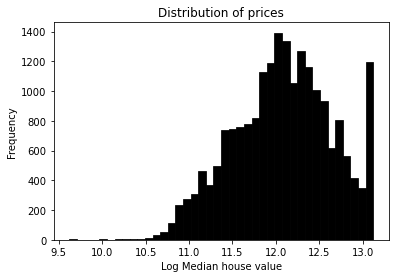

In [6]:
plt.figure(figsize=(6, 4))

log_trans = np.log1p(df.median_house_value)
sns.histplot(log_trans, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log Median house value')
plt.title('Distribution of prices')

plt.show()

# Q1
Find a feature with missing values. How many missing values does it have?

In [7]:
df = df.drop(['ocean_proximity'], axis=1)

In [8]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

&nbsp;

&nbsp;

# Q2 
What's the median (50% percentile) for variable `population`?

In [9]:
df.population.median()

1166.0

***

&nbsp;

&nbsp;

## Validation Network

#### Split the data

- Shuffle the initial dataset, use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Make sure that the target value (`'median_house_value'`) is not in your dataframe.
- Apply the log transformation to the median_house_value variable using the `np.log1p()` function.


In [10]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [11]:
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

&nbsp;

&nbsp;

## Linear Regression

In [12]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

&nbsp;

&nbsp;

## Baseline Regression (fillna=0)

In [13]:
base = ['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income']

In [14]:
#Cleaning
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [15]:
#Training
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [16]:
#Prediction
y_pred = w_0 + X_train.dot(w)

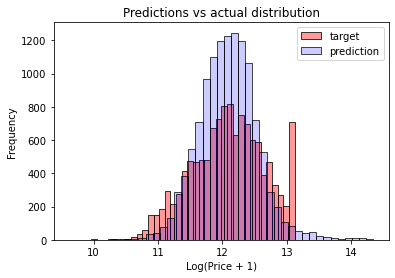

In [17]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='red', alpha=0.4, bins=40)
sns.histplot(y_pred, label='prediction', color='blue', alpha=0.2, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [18]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [19]:
#Quality of prediction when compared to training
score_fillzero = rmse(y_train, y_pred)
round(score_fillzero, 2)

0.34

In [20]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

In [21]:
#Quality of pred
score_fillzero_vs_val = rmse(y_val, y_pred)
round(score_fillzero_vs_val, 2)

0.33

&nbsp;

&nbsp;

## Regression (fillna=mean)

In [22]:
#Cleaning
def prepare_mean_X(df, column):
    df_num = df[base]
    mean_value = df_train[column].mean()
    df_num[column] = df_num[column].fillna(value=mean_value)
    print(df_num.isnull().sum())
    X = df_num.values.astype(float)
    return X

In [23]:
X_train = prepare_mean_X(df_train, "total_bedrooms")

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64


In [24]:
w_0, w = train_linear_regression(X_train, y_train)

In [25]:
y_pred = w_0 + X_train.dot(w)

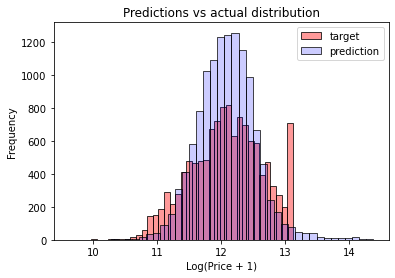

In [26]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='red', alpha=0.4, bins=40)
sns.histplot(y_pred, label='prediction', color='blue', alpha=0.2, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [27]:
#Quality of prediction when compared to training
score_fillmean = rmse(y_train, y_pred)
round(score_fillmean, 2)

0.34

In [28]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

In [29]:
#Quality of pred
score_fillmean_vs_val = rmse(y_val, y_pred)
round(score_fillmean_vs_val, 2)

0.33

***

&nbsp;

# Q3

We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

&nbsp;

The **mean filling** method has the **same RMSE** (0.34 for training dataset and 0.33 for validation dataset) than the one filling only with **zeros**.

&nbsp;

***

# Q4

Now let's train a **regularized linear regression**.
    
- For this question, fill the NAs with 0.
- Try different values of r from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

If there are multiple options, select the smallest `r`.

**Answer:** The best r is 0.01 (RMSE=0.3295319). However RMSE scores rounded to 2 decimal digits will show the same performance for the available options (0, 0.000001, 0.001, 0.0001). So the chosen `r` will be the smallest `r=0.000001`.

## Regularized linear regression

In [30]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [31]:
X_train = prepare_X(df_train)

In [32]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[3], w[7]))

    0, -11.69, -0.00, 0.17
1e-06, -11.69, -0.00, 0.17
0.0001, -11.69, -0.00, 0.17
0.001, -11.67, -0.00, 0.17
 0.01, -11.53, -0.00, 0.17
  0.1, -10.27, -0.00, 0.17
    1, -4.92, -0.00, 0.18
    5, -1.48, -0.00, 0.19
   10, -0.79, -0.00, 0.19


In [33]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred), "|", round(rmse(y_val, y_pred),2))

     0 0.329533036523912 | 0.33
 1e-06 0.3295330361644933 | 0.33
0.0001 0.3295330009701873 | 0.33
 0.001 0.3295327038670615 | 0.33
  0.01 0.32953193659943614 | 0.33
   0.1 0.3296947205389722 | 0.33
     1 0.33378872199973053 | 0.33
     5 0.33924853455008347 | 0.34
    10 0.34060638078081384 | 0.34


***

&nbsp;

&nbsp;

# Q5

We used seed `42` for splitting the data. Let's find out how selecting the seed influences our score.
    
- Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.

What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
Round the result to 3 decimal digits (round(std, 3))

**Answer:** The standard deviation rounded to 3 decimal digits is 0, then the **model is stable**

In [34]:
seed_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for i in seed_list:
    np.random.seed(i)
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx]
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    X_train = prepare_X(df_train)
    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_train.dot(w)
    X_val = prepare_X(df_val)
    y_pred = w_0 + X_val.dot(w)
    #Quality of pred
    RMSE_vs_val = rmse(y_val, y_pred)
    print(round(RMSE_vs_val, 4), end=",", flush=True)

0.5741,0.5735,0.5738,0.5736,0.5737,0.5737,0.5745,0.574,0.574,0.5737,

In [35]:
RMSE_results = [0.5741,0.5735,0.5738,0.5736,0.5737,0.5737,0.5745,0.574,0.574,0.5737]
print(round(np.std(RMSE_results), 6), "\n", round(np.std(RMSE_results), 3))

0.00028 
 0.0


***

&nbsp;

&nbsp;

# Q6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.

What's the RMSE on the test dataset?

The RMSE on the test dataset was 0.3457.

In [38]:
np.random.seed(9)

n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
idx = np.arange(n)

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 0.3365921097119503
test: 0.34570161030099283
